In [501]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [502]:
df = pd.read_csv("insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [503]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


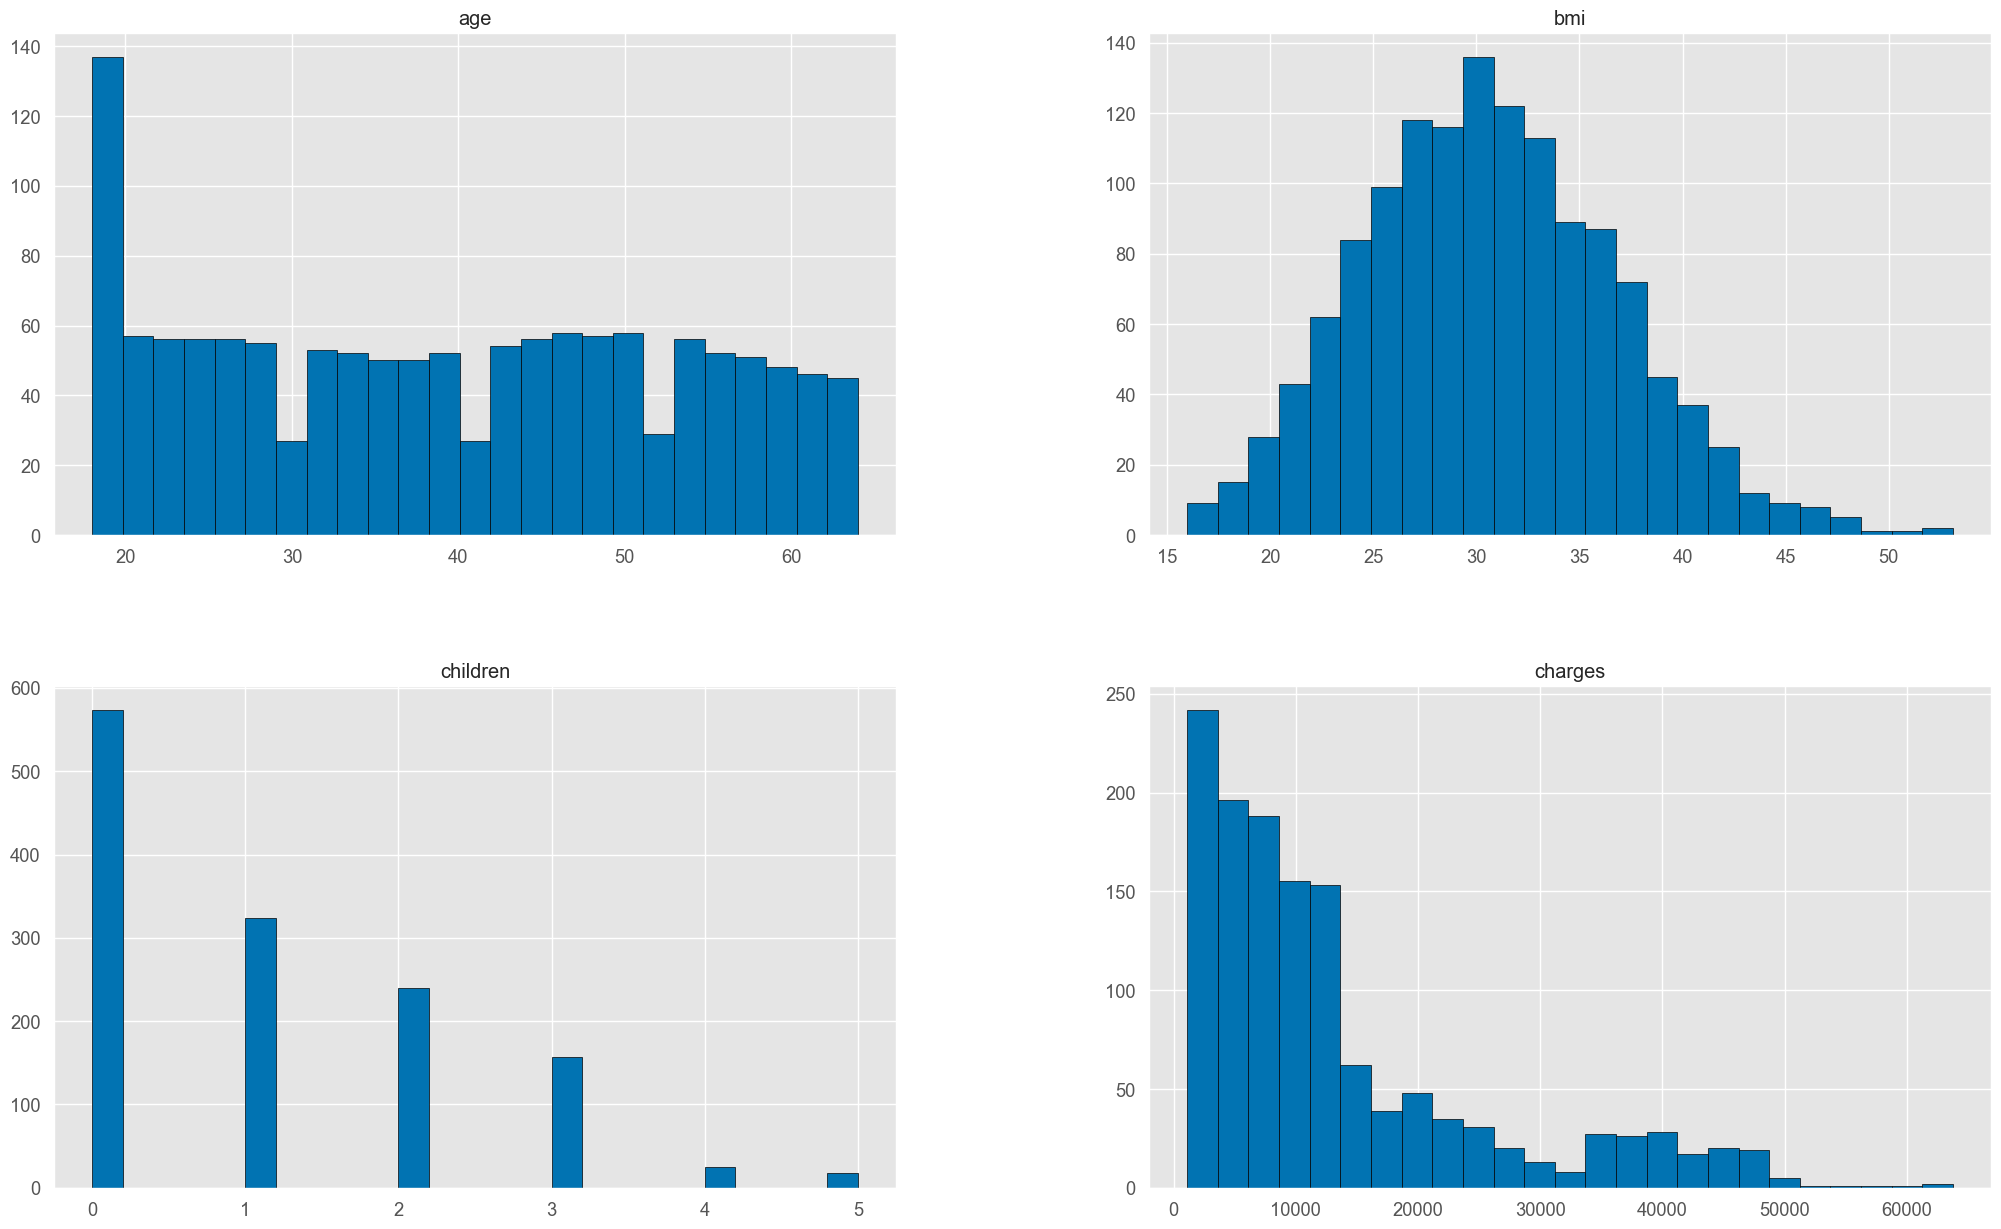

In [504]:
plt.style.use('ggplot') 
sns.set_palette("colorblind")
df.hist(bins=25, figsize=(25,15), edgecolor='black')
plt.show()

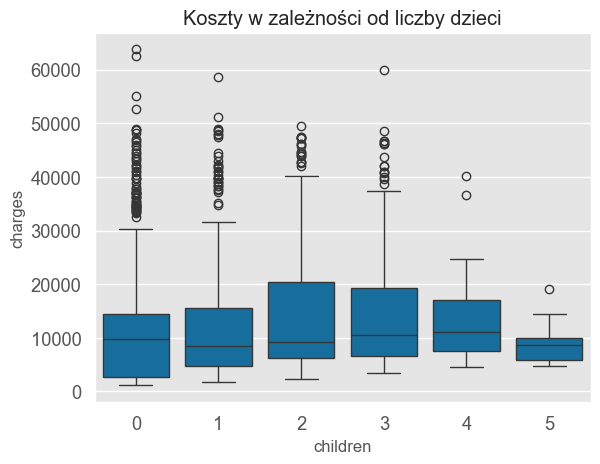

In [505]:
import seaborn as sns

# Boxplot: charges vs children
sns.boxplot(x=df['children'], y=df['charges'])
plt.title("Koszty w zależności od liczby dzieci")
plt.show()

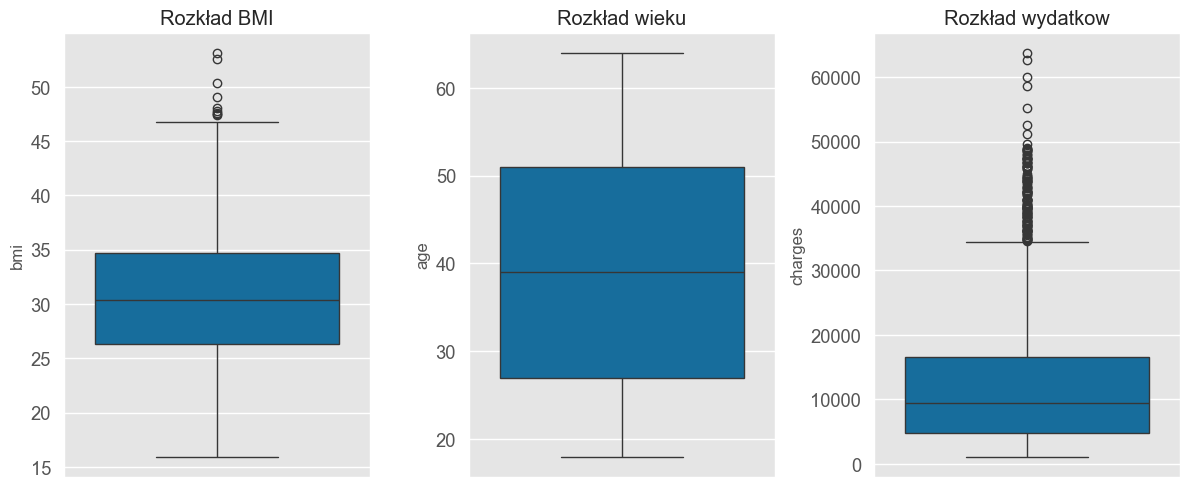

In [506]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tworzymy figurę z dwoma podwykresami w jednym rzędzie
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))  # 1 wiersz, 2 kolumny

# Pierwszy boxplot (BMI)
sns.boxplot(data=df["bmi"], ax=axes[0])
axes[0].set_title("Rozkład BMI")

# Drugi boxplot (Wiek)
sns.boxplot(data=df["age"], ax=axes[1])
axes[1].set_title("Rozkład wieku")

# Trzeci boxplot (charges)
sns.boxplot(data=df["charges"], ax=axes[2])
axes[2].set_title("Rozkład wydatkow")
# Automatyczne dopasowanie layoutu
plt.tight_layout()
plt.show()

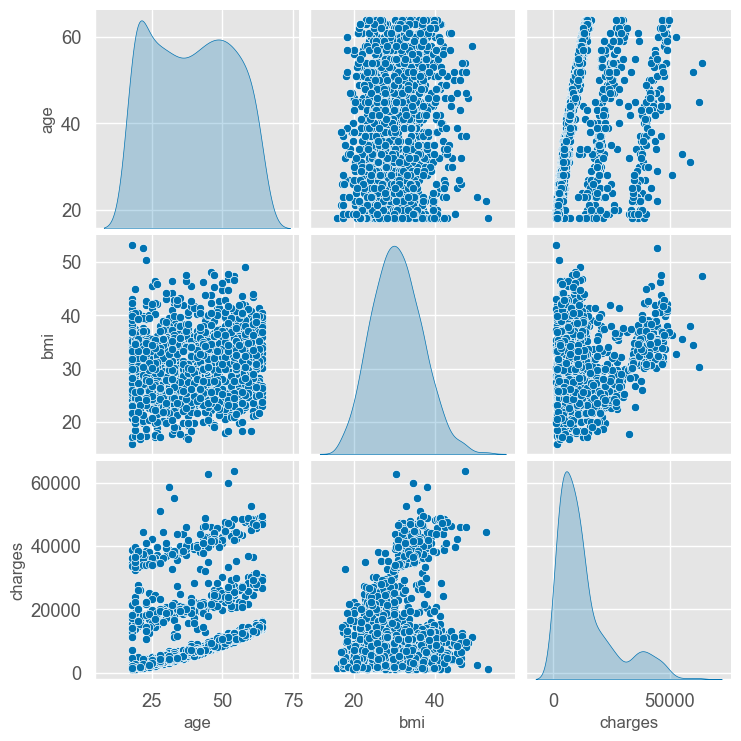

In [507]:
sns.pairplot(df[['age', 'bmi','charges']],
diag_kind='kde')

In [508]:
# średnie i mediany kosztów dla każdego regionu
df.groupby('region')['charges'].agg(['mean', 'median'])

,mean,median
region,,
northeast,13406.384516,10057.652025
northwest,12417.575374,8965.795750
southeast,14735.411438,9294.131950
southwest,12346.937377,8798.593000


Test Shapiro-Wilka dla sprawdzenia normalności

In [509]:
from scipy.stats import shapiro
# Test Shapiro-Wilka sprawdza, czy dane mają rozkład normalny.
# Hipoteza zerowa (H₀): Dane pochodzą z rozkładu normalnego.
# Hipoteza alternatywna (H₁): Dane nie mają rozkładu normalnego.

# Grupowanie danych po regionach
groups = df.groupby('region')['charges'].apply(list)

# Test normalności dla każdej grupy
for region, data in groups.items():
    stat, p_value = shapiro(data)
    print(f'Region {region}: p-value = {p_value:.4f}')

Region northeast: p-value = 0.0000
Region northwest: p-value = 0.0000
Region southeast: p-value = 0.0000
Region southwest: p-value = 0.0000


Interpretacja wyników:
Dla wszystkich regionów p-value = 0.0000 (czyli < 0.05) → Odrzucamy H₀.

Wniosek: Koszty ubezpieczeń nie mają rozkładu normalnego w żadnym z regionów.

Kruskal-Wallis test

In [510]:
from scipy.stats import kruskal

groups = df.groupby("region")["charges"].apply(list)
stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis p-value: {p_value:.4f}")

Kruskal-Wallis p-value: 0.1923


Wynik testu Kruskala-Wallisa (p-value = 0.1923)
Test Kruskala-Wallisa sprawdza, czy przynajmniej jedna grupa ma inną medianę niż pozostałe. Jest nieparametrycznym odpowiednikiem ANOVA i nie wymaga założenia normalności ani równości wariancji.

Interpretacja:
p-value = 0.1923 (czyli > 0.05) → Nie ma podstaw do odrzucenia hipotezy zerowej.

Wniosek: Nie stwierdzono istotnych statystycznie różnic w medianach kosztów między regionami.

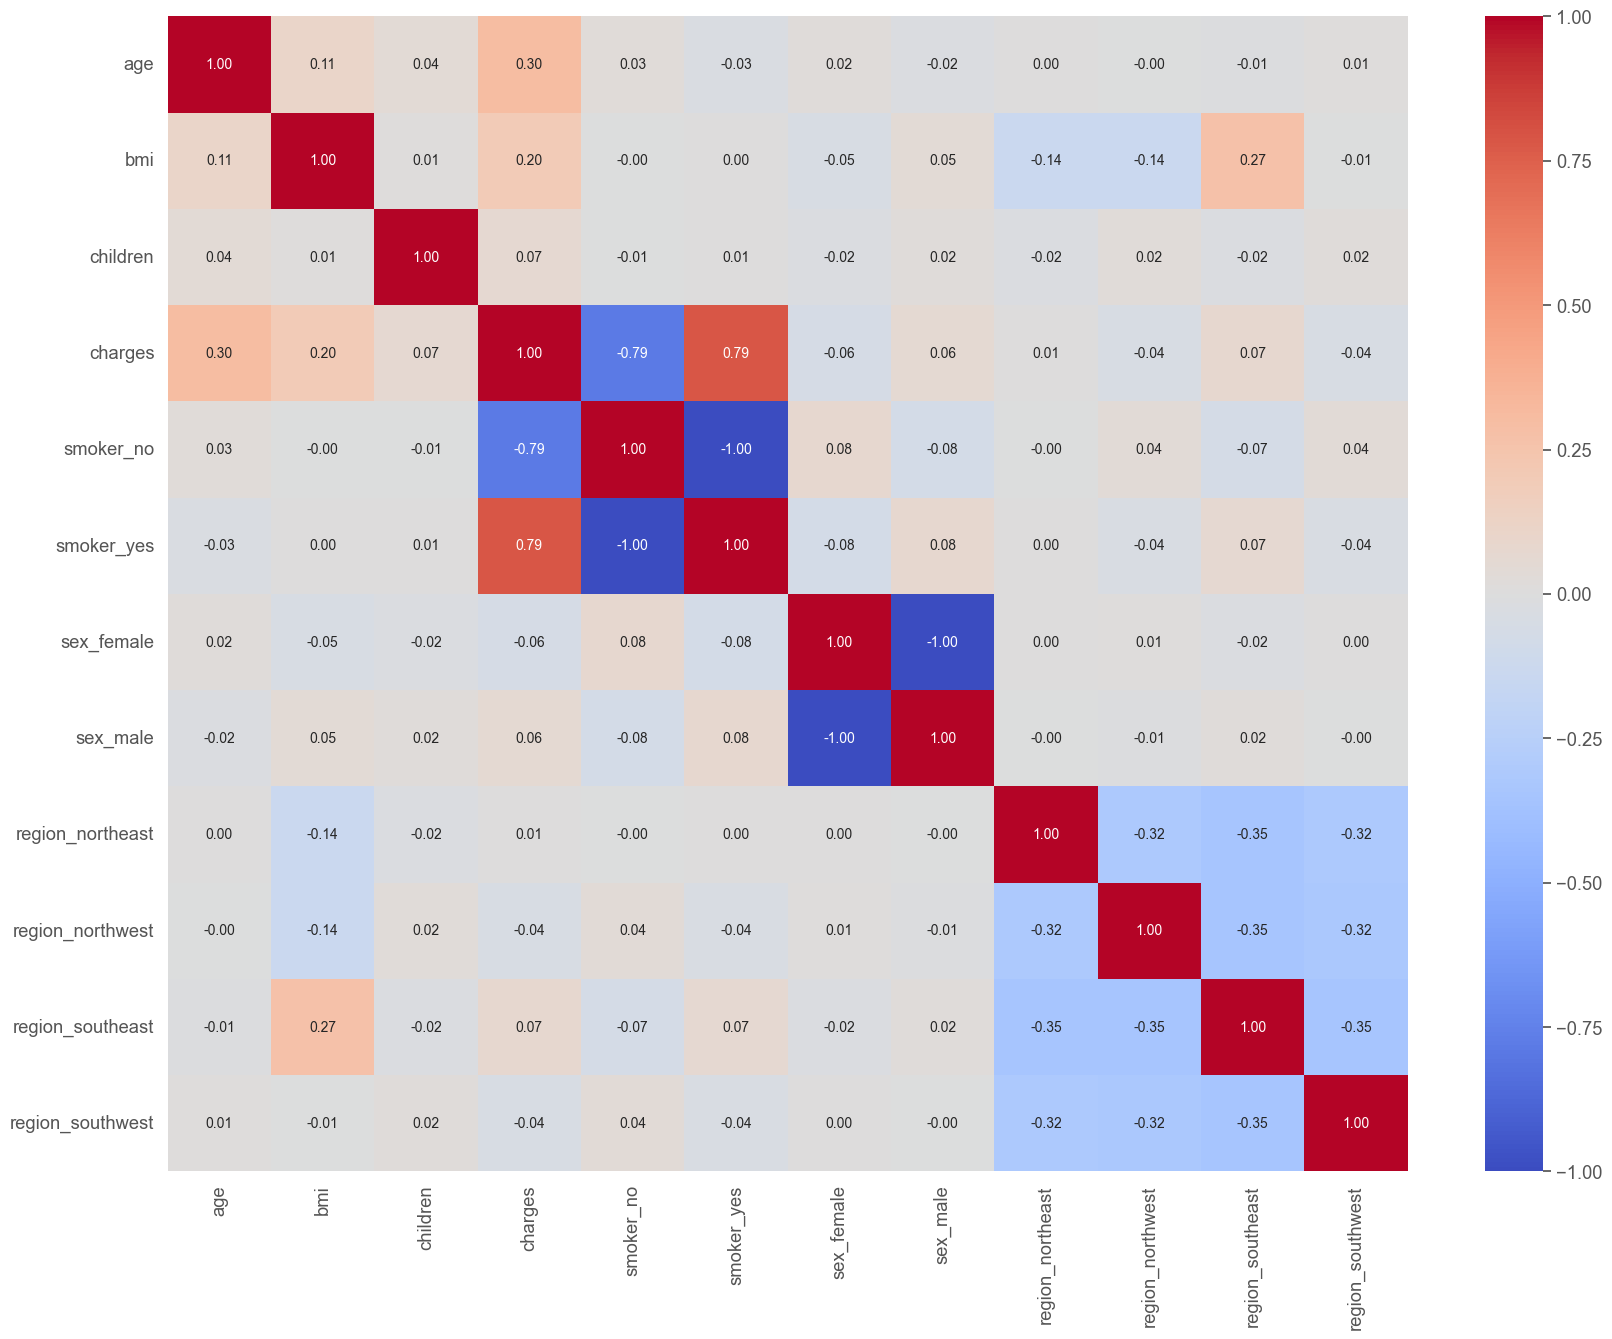

In [511]:
# macierz korelacji
df = pd.get_dummies(df, columns=['smoker','sex','region'], dtype=int)
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

smoker_yes vs charges: 0.79
Najwyższa korelacja w całym zbiorze – status palacza jest głównym predyktorem wysokich kosztów. Oznacza to, że osoby palące generują średnio znacznie więcej kosztów za ubezpieczenie.
W modelach ML zmienna smoker_yes będzie miała dużą moc predykcyjną.
Umiarkowane korelacje innych zmiennych
age vs charges: 0.30
Wiek ma umiarkowany wpływ – starsze osoby generują wyższe koszty (np. z powodu większej liczby schorzeń).
bmi vs charges: 0.20
Wyższe BMI (nadwaga/otyłość) wiąże się z nieco wyższymi kosztami, ale efekt jest słabszy niż w przypadku palenia.
 Brak istotnych korelacji z regionem
Wszystkie regiony (northeast, northwest, southeast, southwest) mają bardzo niskie korelacje z charges
 (maks. 0.07).

In [512]:
from sklearn.preprocessing import MinMaxScaler
# Inicjalizacja skalera
scaler = MinMaxScaler()
# Normalizacja kolumn 'age' i 'bmi'
df[['age_norm', 'bmi_norm']] = scaler.fit_transform(df[['age', 'bmi']])
# Wynik
# print(df[['age_norm', 'bmi_norm']])
# Dlaczego normalizować?
# Niektóre algorytmy (np. sieci neuronowe, SVM, KNN) 
# wymagają skalowania danych, aby cechy o większych zakresach wartości nie dominowały nad innymi.


In [513]:
print(df.columns)

Index(['age', 'bmi', 'children', 'charges', 'smoker_no', 'smoker_yes',
       'sex_female', 'sex_male', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest', 'age_norm', 'bmi_norm'],
      dtype='object')


In [514]:
# model regresji liniowej, aby ocenić wkład poszczególnych zmiennych w koszty.
import statsmodels.api as sm

X = df[['age', 'bmi', 'smoker_yes', 'children']]
X = sm.add_constant(X)
y = df['charges']

model = sm.OLS(y, X).fit()
print(model.summary())#

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     998.1
Date:                Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:39:16   Log-Likelihood:                -13551.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1333   BIC:                         2.714e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.21e+04    941.984    -12.848      0.0

Podstawowe informacje o modelu
Zmienna objaśniana (Dep. Variable): charges (koszty ubezpieczeń).
R-squared = 0.750: Model wyjaśnia 75% zmienności kosztów ubezpieczeń.
Adj. R-squared = 0.749: Po uwzględnieniu liczby zmiennych, model nadal wyjaśnia 74.9% zmienności.
F-statistic = 998.1 (p-value = 0.00): Model jest statystycznie istotny jako całość.
Liczba obserwacji: 1338.
Współczynniki regresji
Zmienna	Współczynnik	Interpretacja merytoryczna
const	-12 100	Gdy wszystkie zmienne = 0, koszt ubezpieczenia wynosi -12 100 USD (brak sensu fizycznego – wynika z ekstrapolacji poza zakres danych).
age	257.85	Każdy dodatni rok życia zwiększa koszty o ~258 USD (przy założeniu stałości pozostałych zmiennych).
bmi	321.85	Każdy dodatni punkt BMI zwiększa koszty o ~322 USD.
smoker_yes	23 810	Osoby palące podnoszą koszt średnio o 23 810 USD więcej niż niepalący (najsilniejszy efekt w modelu).
children	473.50	Każde dodatnie dziecko zwiększa koszty o ~474 USD.
Istotność statystyczna
Wszystkie zmienne mają p-value = 0.000 → są istotne statystycznie na poziomie α = 0.05.
Największy wpływ: smoker_yes (t = 57.9) – palenie jest kluczowym czynnikiem kosztów.
Diagnostyka modelu
Nienormalność reszt:
Jarque-Bera (JB) = 722.16 (p-value ≈ 0) → reszty nie mają rozkładu normalnego.
Skewness = 1.215: Rozkład reszt jest prawostronnie skośny (wiele niskich wartości + kilka ekstremalnie wysokich).
Kurtosis = 5.654: Reszty mają grubsze ogony niż rozkład normalny (obecność outlierów).
Autokorelacja reszt:
Durbin-Watson = 2.087 → brak silnej autokorelacji (wartości bliskie 2 wskazują na losowość reszt).
Podsumowanie i rekomendacje
Główne wnioski:
Palenie (smoker_yes) ma przeważający wpływ na koszty ubezpieczeń.
Wiek i BMI również istotnie zwiększają koszty, ale ich efekt jest znacznie słabszy.
Problemy z modelem:
Nienormalność reszt i wysoka kurtoza sugerują, że wyniki mogą być zaburzone przez ekstremalne wartości w zmiennej charges.
Ujemny intercept (const = -12 100) jest niefizyczny – oznacza, że model nie radzi sobie z ekstrapolacją dla skrajnych wartości.

In [515]:
# dodanie cechy

df['smoker_bmi'] = df['smoker_yes'] * df['bmi']

In [516]:
# Podział na cechy (X) i target (y)

X = df[['age_norm', 'bmi_norm', 'children', "smoker_bmi"]]
y = df['charges']

In [517]:
print(X.columns)

Index(['age_norm', 'bmi_norm', 'children', 'smoker_bmi'], dtype='object')


In [518]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [519]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [520]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1070, 4), (268, 4), (1070,), (268,))

In [521]:
# 1. Inicjalizacja modelu
model = LinearRegression() # Tworzy pusty obiekt modelu regresji liniowej.
    # Jak działa regresja liniowa?
    # Model próbuje znaleźć liniową zależność między cechami (kolumny w X_train_scaled) a targetem (y_train).
    # Równanie modelu:y = β₀ + β₁*x₁ + β₂*x₂ + ... + βₙ*xₙ
    # gdzie:
        # β₀ – intercept (wyraz wolny),
        # β₁...βₙ – współczynniki dla cech.
# 2. Trenowanie modelu
model.fit(X_train, y_train) 
    # Uczy model na danych treningowych, aby znalazł optymalne współczynniki β₀, β₁, ..., βₙ.
    # Proces treningu:
        # Algorytm minimalizuje błąd średniokwadratowy (MSE) między przewidywaniami modelu 
        # a prawdziwymi wartościami y_train,
        # Używa metody najmniejszych kwadratów (OLS – Ordinary Least Squares).

LinearRegression()

In [522]:
# MSE, RMSE, MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_error
y_pred = model.predict(X_test) #przewidywanie warotści dla modelu 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mse)
print("RMSE", rmse)
print("MAE", mae)

R²: 0.8492434489424179
MSE: 23404763.315764397
RMSE 4837.846971098238
MAE 3100.1722416994708


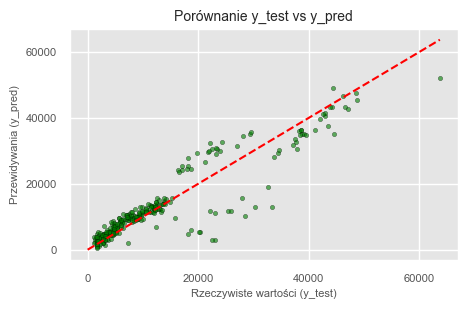

In [523]:
import matplotlib.pyplot as plt

# Porównanie rozkładu y_test i y_pred
plt.figure(figsize=(5, 3))
plt.xticks(fontsize=8) 
plt.yticks(fontsize=8) 
plt.scatter(
    y_test, 
    y_pred, 
    s=10,           # Rozmiar punktów (domyślnie 20-50, tutaj mniejsze)
    c='green',  # Kolor (może być nazwa, hex, np. '#1f77b4')
    alpha=0.6,      # Przezroczystość (0-1)
    edgecolor='black',  # Kolor obramówki punktów
    linewidth=0.3    # Grubość obramówki
)
plt.plot([6, max(y_test)], [6, max(y_test)], color='red', linestyle='--')  # Linia idealnych przewidywań
plt.xlabel("Rzeczywiste wartości (y_test)", fontsize=8)
plt.ylabel("Przewidywania (y_pred)", fontsize=8)
plt.title("Porównanie y_test vs y_pred", fontsize=10)
plt.show()